#Importing all Required Libraries and packages

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import keras
from keras.layers import Dense, Embedding, LSTM, Dropout,SimpleRNN
from keras.models import Sequential
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping,ModelCheckpoint
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import nltk
import string
import re
from nltk.stem.wordnet import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
from keras.callbacks import EarlyStopping
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report
from sklearn.metrics import confusion_matrix
from keras.layers.convolutional import Conv1D
from keras.layers import Dense, Input,Reshape,Concatenate,Flatten
from keras.layers import MaxPooling1D
from keras.models import Sequential, Model, load_model
from keras import regularizers
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub


#Downloading the dataset from shared googledrive and saving it in a variable

In [ ]:
##download test dataset
!gdown --id "1rshUMSv5MJj_nNzXpNWsbkU0Y65UYLJN"
##download test dataset
!gdown --id "10HbGYRRaqvx4RctKIm5o7mmpXAGPVw59"

Downloading...
From: https://drive.google.com/uc?id=1rshUMSv5MJj_nNzXpNWsbkU0Y65UYLJN
To: /content/test.csv
10.1MB [00:00, 89.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=10HbGYRRaqvx4RctKIm5o7mmpXAGPVw59
To: /content/train.csv
358MB [00:03, 118MB/s] 


In [ ]:
trainpath="/content/train.csv"
train_data=pd.read_csv(trainpath)
testpath="/content/test.csv"
test_data=pd.read_csv(testpath)

In [ ]:
##reading train data
train_data.head()

,Artist,Song,Genre,Language,Lyrics
0,12 stones,world so cold,Rock,en,"It starts with pain, followed by hate\nFueled ..."
1,12 stones,broken,Rock,en,Freedom!\nAlone again again alone\nPatiently w...
2,12 stones,3 leaf loser,Rock,en,"Biting the hand that feeds you, lying to the v..."
3,12 stones,anthem for the underdog,Rock,en,You say you know just who I am\nBut you can't ...
4,12 stones,adrenaline,Rock,en,My heart is beating faster can't control these...


In [ ]:
#reading test data
test_data.head()

,Song,Song year,Artist,Genre,Lyrics,Track_id
0,craftsmanship,2005,buck-65,Hip-Hop,Most folks spend their days daydreaming of fin...,8294
1,come-on-out,2012,the-elwins,Indie,Take your cold hands and put them on my face\n...,21621
2,riot,2013,bullet-for-my-valentine,Metal,Are you ready it's time for war\nWe'll break d...,3301
3,that-s-what-girls-do,2007,dream-street,Pop,You ask me why I change the color of my hair\n...,2773
4,believe-in-a-dollar,2012,cassidy,Hip-Hop,Do you believe in magic in a young girl's hear...,16797


#Cleaning and Preprocessing

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemer = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
punctuations = string.punctuation
nltk.download('wordnet')
lem = WordNetLemmatizer()
 
def clean(text):
 
 cleaned_text = str(text).lower()
 cleaned_text = "".join(c for c in cleaned_text if c not in punctuations) 
 words = cleaned_text.split() 
 words = [i for i in words if i.isalpha()]
 pattern = '[0-9]'
 words = [re.sub(r'[^a-zA-Z]+$', '', i) for i in words]
 words = [re.sub(pattern, '', i) for i in words]
 words = " ".join(words)
 #words=[stemer.stem(word) for word in words.split(" ") if words not in stop_words]
 #words = [lem.lemmatize(word, pos='a') for word in words] 
 cleaned_text = "".join(words) 
 return cleaned_text

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
train_data.dropna(inplace=True)

In [ ]:
train_data.isna().sum()

Artist      0
Song        0
Genre       0
Language    0
Lyrics      0
dtype: int64

In [ ]:
train_data["train_cleanedlyrics"] = train_data["Lyrics"].apply(clean)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'genre_count')

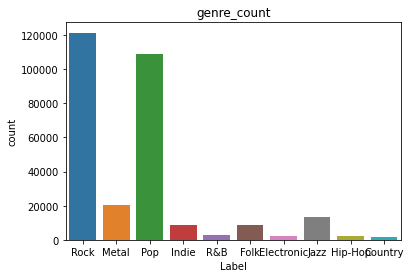

In [ ]:
sns.countplot(train_data["Genre"])
plt.xlabel('Label')
plt.title('genre_count')

In [ ]:
le = LabelEncoder()
train_data['genre_cat']=le.fit_transform(train_data['Genre'])
y_lyr = to_categorical(train_data['genre_cat'], num_classes=10)
n_most_common_words = 10000
max_len = 50
tokenizer = Tokenizer(num_words=n_most_common_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(train_data["train_cleanedlyrics"].values)
sequences = tokenizer.texts_to_sequences(train_data["train_cleanedlyrics"].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
x_lyr = pad_sequences(sequences, maxlen=max_len)

Found 378499 unique tokens.


In [ ]:
train_data.head()

,Artist,Song,Genre,Language,Lyrics,train_cleanedlyrics,genre_cat
0,12 stones,world so cold,Rock,en,"It starts with pain, followed by hate\nFueled ...",it starts with pain followed by hate fueled by...,9
1,12 stones,broken,Rock,en,Freedom!\nAlone again again alone\nPatiently w...,freedom alone again again alone patiently wait...,9
2,12 stones,3 leaf loser,Rock,en,"Biting the hand that feeds you, lying to the v...",biting the hand that feeds you lying to the vo...,9
3,12 stones,anthem for the underdog,Rock,en,You say you know just who I am\nBut you can't ...,you say you know just who i am but you cant im...,9
4,12 stones,adrenaline,Rock,en,My heart is beating faster can't control these...,my heart is beating faster cant control these ...,9


In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(x_lyr ,y_lyr , test_size=0.2, random_state=42)

epochs = 10
emb_dim = 150
batch_size = 1000
print((x_train.shape, y_train.shape, x_valid.shape, y_valid.shape))


((232114, 50), (232114, 10), (58029, 50), (58029, 10))


#Building Simple RNN Model

In [ ]:
n_most_common_words=10000
model_simplernn = Sequential([Embedding(
       n_most_common_words, emb_dim, input_length=x_lyr.shape[1],mask_zero=True),
       SimpleRNN(units=32, activation="relu"),
        Dense(10, activation = 'softmax')])

In [ ]:
model_simplernn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 150)           1500000   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                5856      
_________________________________________________________________
dense (Dense)                (None, 10)                330       
Total params: 1,506,186
Trainable params: 1,506,186
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_simplernn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
hist_simplernn = model_simplernn.fit(x_train,y_train, epochs=10,batch_size=1000,

                    validation_data=(x_valid,y_valid))

Epoch 1/10
233/233 [==============================] - 35s 136ms/step - loss: 1.7865 - acc: 0.3964 - val_loss: 1.3037 - val_acc: 0.5409
Epoch 2/10
233/233 [==============================] - 31s 134ms/step - loss: 1.2548 - acc: 0.5527 - val_loss: 1.2446 - val_acc: 0.5635
Epoch 3/10
233/233 [==============================] - 31s 133ms/step - loss: 1.1525 - acc: 0.5971 - val_loss: 1.2029 - val_acc: 0.5782
Epoch 4/10
233/233 [==============================] - 31s 133ms/step - loss: 1.0773 - acc: 0.6244 - val_loss: 1.2012 - val_acc: 0.5756
Epoch 5/10
233/233 [==============================] - 31s 133ms/step - loss: 1.0242 - acc: 0.6462 - val_loss: 1.2163 - val_acc: 0.5762
Epoch 6/10
233/233 [==============================] - 31s 133ms/step - loss: 0.9801 - acc: 0.6628 - val_loss: 1.2293 - val_acc: 0.5775
Epoch 7/10
233/233 [==============================] - 31s 133ms/step - loss: 0.9426 - acc: 0.6774 - val_loss: 1.2417 - val_acc: 0.5858
Epoch 8/10
233/233 [==============================] - 3

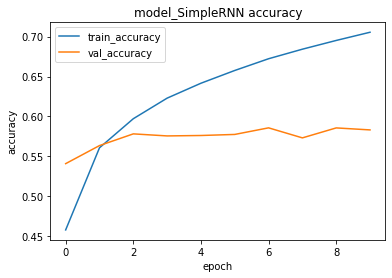

In [ ]:
##training vs Validation accuracy for simpleRNN model
plt.plot(hist_simplernn.history['acc'])
plt.plot(hist_simplernn.history['val_acc'])
plt.title('model_SimpleRNN accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'], loc='upper left')
plt.show()

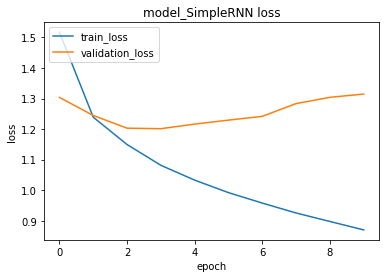

In [ ]:
##training vs Validation loss for SimpleRNN model
plt.plot(hist_simplernn.history['loss'])
plt.plot(hist_simplernn.history['val_loss'])
plt.title('model_SimpleRNN loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'validation_loss'], loc='upper left')
plt.show()

#Building LSTM MODEL

In [ ]:
modellstm = Sequential()
modellstm.add(Embedding(n_most_common_words, emb_dim, input_length=x_lyr.shape[1]))
modellstm.add(LSTM(100, dropout=0.15, recurrent_dropout=0.15))
modellstm.add(Dense(16, activation='relu'))
modellstm.add(Dense(10, activation='softmax'))
modellstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
print(modellstm.summary())


earlystop = EarlyStopping(monitor = 'val_loss',min_delta = 0,patience = 3, verbose = 1,restore_best_weights = True)
#checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
#callbacks_list = [checkpoint]

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 150)           1500000   
_________________________________________________________________
lstm (LSTM)                  (None, 100)               100400    
_________________________________________________________________
dense_1 (Dense)              (None, 16)                1616      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                170       
Total params: 1,602,186
Trainable params: 1,602,186
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
hist_lstm=modellstm.fit(x_train, y_train, epochs=10, batch_size=1000,validation_data=(x_valid,y_valid),callbacks=[earlystop])

# load and evaluate a saved model 
# load model


Epoch 1/10
233/233 [==============================] - 80s 333ms/step - loss: 1.6509 - acc: 0.4115 - val_loss: 1.2405 - val_acc: 0.5598
Epoch 2/10
233/233 [==============================] - 76s 326ms/step - loss: 1.2032 - acc: 0.5768 - val_loss: 1.1892 - val_acc: 0.5818
Epoch 3/10
233/233 [==============================] - 77s 329ms/step - loss: 1.1363 - acc: 0.6042 - val_loss: 1.1721 - val_acc: 0.5835
Epoch 4/10
233/233 [==============================] - 77s 330ms/step - loss: 1.0980 - acc: 0.6196 - val_loss: 1.1562 - val_acc: 0.5917
Epoch 5/10
233/233 [==============================] - 76s 328ms/step - loss: 1.0599 - acc: 0.6337 - val_loss: 1.1563 - val_acc: 0.5948
Epoch 6/10
233/233 [==============================] - 76s 327ms/step - loss: 1.0264 - acc: 0.6427 - val_loss: 1.1549 - val_acc: 0.5971
Epoch 7/10
233/233 [==============================] - 76s 328ms/step - loss: 1.0001 - acc: 0.6547 - val_loss: 1.1637 - val_acc: 0.5959
Epoch 8/10
233/233 [==============================] - 7

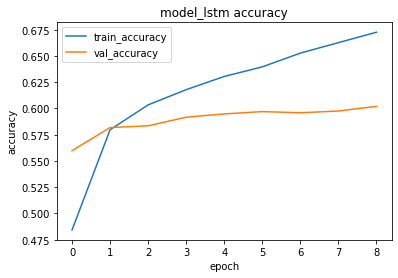

In [ ]:
##training vs Validation accuracy for RNN LSTM model
plt.plot(hist_lstm.history['acc'])
plt.plot(hist_lstm.history['val_acc'])
plt.title('model_lstm accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'], loc='upper left')
plt.show()

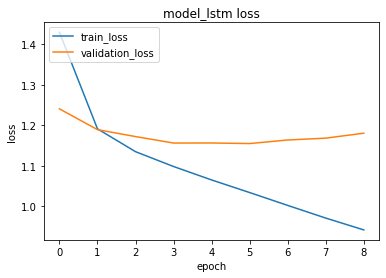

In [ ]:
##training vs Validation loss for RNN LSTM model
plt.plot(hist_lstm.history['loss'])
plt.plot(hist_lstm.history['val_loss'])
plt.title('model_lstm loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'validation_loss'], loc='upper left')
plt.show()

Saving LSTM model

In [ ]:
##Saving Pretrained model from tensorflowhub
modellstm.save("/content/drive/MyDrive/Assignment_data/modellstm.h5")
#https://drive.google.com/file/d/1-2Llxr0o-y_8cD8lOLoFHcaJL3I8Kbq_/view?usp=sharing


#Analysing Test data

In [ ]:
test_data.head()
test_data.isna().sum()

Song         0
Song year    0
Artist       0
Genre        0
Lyrics       0
Track_id     0
dtype: int64

In [ ]:
test_data["test_cleanedlyrics"] = test_data["Lyrics"].apply(clean)

In [ ]:

#label Encoding Target of test data and tokenizing the lyrics in test data as like train data
test_data['genre_cat']=le.fit_transform(test_data['Genre'])
ytest_lyr = to_categorical(test_data['genre_cat'], num_classes=10)

n_most_common_words = 10000
max_len = 50

testsequences = tokenizer.texts_to_sequences(test_data["test_cleanedlyrics"].values)
testword_index = tokenizer.word_index
print('Found %s unique tokens.' % len(testword_index))
testx_lyr = pad_sequences(testsequences, maxlen=max_len)

Found 378499 unique tokens.


#Evaluating the simpleRNN and LSTM Model on Test Data

In [ ]:
#testx_lyr = pad_sequences(testsequences, maxlen=max_len)
##EVALUATION ON TEST DATA USING SIMPLE_RNN
actual_testpreds=model_simplernn.predict(testx_lyr)
actual_testpreds=actual_testpreds.argmax(axis=1)
final_testpred=le.inverse_transform(actual_testpreds)
actual_y=test_data["Genre"]
pred_y=final_testpred
print(confusion_matrix(actual_y, pred_y))
print(classification_report(actual_y, pred_y))

[[  0   0  13   0   0  27  10 195   0 565]
 [  0   0   2   1   1   3  31 316   0 306]
 [  0   0  13   0   2  13  31 129   0 307]
 [  0   0   2   1   2   7  17 742   0 189]
 [  0   1   3   0   2  10  25 167   0 302]
 [  0   0   0   0   0 112   7 205   0 336]
 [  0   0   0   0   1   6 329 154   0 320]
 [  0   0   3   0   1  26  25 575   0 480]
 [  0   0   1   0   4   7  21 243   3 231]
 [  0   0   4   0   2  18  77 436   0 873]]
              precision    recall  f1-score   support

     Country       0.00      0.00      0.00       810
  Electronic       0.00      0.00      0.00       660
        Folk       0.32      0.03      0.05       495
     Hip-Hop       0.50      0.00      0.00       960
       Indie       0.13      0.00      0.01       510
        Jazz       0.49      0.17      0.25       660
       Metal       0.57      0.41      0.48       810
         Pop       0.18      0.52      0.27      1110
         R&B       1.00      0.01      0.01       510
        Rock       0.22     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
##EVALUATION ON TEST DATA USING SIMPLE_RNN OVERALL SCORES
##overall accuracy score
accuracy = accuracy_score(actual_y, pred_y)
print('Accuracy: %f' % accuracy)
#overall precision score
precision = precision_score(actual_y, pred_y,average='weighted')
print('Precision: %f' % precision)
#overall f1 score
f1 = f1_score(actual_y, pred_y,average='micro')
print('F1 score: %f' % f1)
recal = recall_score(actual_y, pred_y,average='micro')
print('recall score: %f' % recal)

Accuracy: 0.240454
Precision: 0.317526
F1 score: 0.240454
recall score: 0.240454


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
##EVALUATION ON TEST DATA USING RNN_LSTM
actual_testpreds=modellstm.predict(testx_lyr)
actual_testpreds=actual_testpreds.argmax(axis=1)
final_testpred=le.inverse_transform(actual_testpreds)
actual_y=test_data["Genre"]
pred_y=final_testpred
print(confusion_matrix(actual_y, pred_y))
print(classification_report(actual_y, pred_y))

[[   0    0    1    0    0   23   11   83    0  692]
 [   0    0    0    0    0    4   46  231    0  379]
 [   0    0    0    0    1   16   23   67    0  388]
 [   0    0    0    0    0    1   16  711    0  232]
 [   0    0    0    0    1    4   19  103    0  383]
 [   0    0    0    0    0  147    8   99    0  406]
 [   0    0    0    0    0    0  417   82    0  311]
 [   0    0    0    0    0   27   27  420    0  636]
 [   0    0    0    0    0   11   20  163    0  316]
 [   0    0    0    0    1   13   98  258    0 1040]]
              precision    recall  f1-score   support

     Country       0.00      0.00      0.00       810
  Electronic       0.00      0.00      0.00       660
        Folk       0.00      0.00      0.00       495
     Hip-Hop       0.00      0.00      0.00       960
       Indie       0.33      0.00      0.00       510
        Jazz       0.60      0.22      0.32       660
       Metal       0.61      0.51      0.56       810
         Pop       0.19      0.38   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
##EVALUATION ON TEST DATA USING RNN_LSTM Overall Scores
##overall accuracy score
accuracy = accuracy_score(actual_y, pred_y)
print('Accuracy: %f' % accuracy)
#overall precision score
precision = precision_score(actual_y, pred_y,average='weighted')
print('Precision: %f' % precision)
#overall f1 score
f1 = f1_score(actual_y, pred_y,average='micro')
print('F1 score: %f' % f1)
recal = recall_score(actual_y, pred_y,average='micro')
print('recall score: %f' % recal)

Accuracy: 0.255198
Precision: 0.198406
F1 score: 0.255198
recall score: 0.255198


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Pretrained using Glove and pretrained word Embeddings from tensorflow hub

In [ ]:
##With pretrained glove embeddings
!wget john.mccr.ae/downloads/glove.6B.50d.txt.gz
!gunzip glove.6B.50d.txt.gz
path_to_glove_file = "glove.6B.50d.txt"


--2021-05-07 10:57:38--  http://john.mccr.ae/downloads/glove.6B.50d.txt.gz
Resolving john.mccr.ae (john.mccr.ae)... 128.199.47.101
Connecting to john.mccr.ae (john.mccr.ae)|128.199.47.101|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 69182520 (66M) [application/x-gzip]
Saving to: ‘glove.6B.50d.txt.gz’

glove.6B.50d.txt.gz 100%[===================>]  65.98M   237MB/s    in 0.3s    

2021-05-07 10:57:38 (237 MB/s) - ‘glove.6B.50d.txt.gz’ saved [69182520/69182520]



In [ ]:
import numpy as np
embeddings_index = {}
with open(path_to_glove_file,'r', encoding="utf-8") as f:
  for line in f:
    values=line.split()
    word=values[0]
    coefs=np.asarray(values[1:],dtype='float32')
    embeddings_index[word]=coefs
  f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
#vocab_size = 1000
#oov_token = "<OOV>"
max_length = 50
#padding_type = "post"
#trunction_type="post"
embedding_matrix = np.zeros((len(word_index) + 1, max_length))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [ ]:
##Adding a embedding layer of pretrained unlike  embedding layer which was added in previous LSTM model
embedding_layer = Embedding(len(word_index) + 1,
                            max_length,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)

In [ ]:
##INITIALIZING PRETRAINED MODEL USING GLOVE
from keras.layers import Dense, Embedding, LSTM, Bidirectional
embedding_dim = 100
input_length = 50
modelpretrained = Sequential([embedding_layer,
  Bidirectional(LSTM(embedding_dim, return_sequences=True)),
  Bidirectional(LSTM(embedding_dim,)),
  Dense(128, activation='relu'),
  Dense(10, activation='softmax')
])
#filepath="modelpretrained.hdf5"
earlystop = EarlyStopping(monitor = 'val_loss',min_delta = 0,patience = 3, verbose = 1,restore_best_weights = True)
modelpretrained.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])


In [ ]:
print(modelpretrained.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 50)            18925000  
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 200)           120800    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               240800    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               25728     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
Total params: 19,313,618
Trainable params: 388,618
Non-trainable params: 18,925,000
_________________________________________________________________
None


In [ ]:
num_epochs=10
hist_pretrained=modelpretrained.fit(x_train, y_train,batch_size=1000, epochs=num_epochs, validation_data=(x_valid, y_valid),callbacks=[earlystop])
#modelpretrained.save("model.pretrain")
#modelpretrained = load_model('model.pretrain')


Epoch 1/10
233/233 [==============================] - 78s 193ms/step - loss: 1.4343 - accuracy: 0.4636 - val_loss: 1.3215 - val_accuracy: 0.4874
Epoch 2/10
233/233 [==============================] - 43s 186ms/step - loss: 1.3006 - accuracy: 0.5038 - val_loss: 1.2804 - val_accuracy: 0.5146
Epoch 3/10
233/233 [==============================] - 43s 185ms/step - loss: 1.2639 - accuracy: 0.5224 - val_loss: 1.2648 - val_accuracy: 0.5195
Epoch 4/10
233/233 [==============================] - 43s 186ms/step - loss: 1.2436 - accuracy: 0.5333 - val_loss: 1.2555 - val_accuracy: 0.5290
Epoch 5/10
233/233 [==============================] - 43s 186ms/step - loss: 1.2276 - accuracy: 0.5435 - val_loss: 1.2289 - val_accuracy: 0.5448
Epoch 6/10
233/233 [==============================] - 43s 185ms/step - loss: 1.2061 - accuracy: 0.5541 - val_loss: 1.2222 - val_accuracy: 0.5397
Epoch 7/10
233/233 [==============================] - 43s 186ms/step - loss: 1.1878 - accuracy: 0.5621 - val_loss: 1.2101 - val_ac

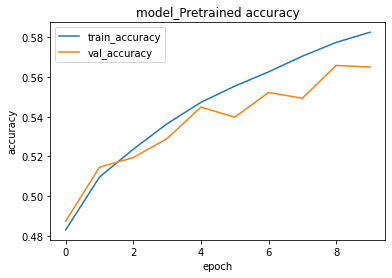

In [ ]:
##training vs Validation accuracy for Pretrained Glove
plt.plot(hist_pretrained.history['accuracy'])
plt.plot(hist_pretrained.history['val_accuracy'])
plt.title('model_Pretrained accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy','val_accuracy'], loc='upper left')
plt.show()

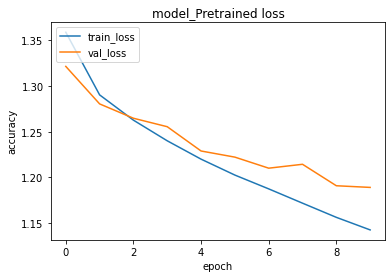

In [ ]:
##training vs Validation Loss for Pretrained Glove 
plt.plot(hist_pretrained.history['loss'])
plt.plot(hist_pretrained.history['val_loss'])
plt.title('model_Pretrained loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'], loc='upper left')
plt.show()

In [ ]:
test_data['genre_cat']=le.fit_transform(test_data['Genre'])
ytest_lyr = to_categorical(test_data['genre_cat'], num_classes=10)

n_most_common_words = 10000
max_len = 50

testsequences = tokenizer.texts_to_sequences(test_data["test_cleanedlyrics"].values)
testword_index = tokenizer.word_index
print('Found %s unique tokens.' % len(testword_index))
testx_lyr = pad_sequences(testsequences, maxlen=max_len)

Found 378499 unique tokens.


In [ ]:
##EVALUATION ON TEST DATA USING Pretrained glove
actual_testpreds=modelpretrained.predict(testx_lyr)
actual_testpreds=actual_testpreds.argmax(axis=1)
final_testpred=le.inverse_transform(actual_testpreds)
actual_y=test_data["Genre"]
pred_y=final_testpred
print(confusion_matrix(actual_y, pred_y))
print(classification_report(actual_y, pred_y))

[[   0    0    0    0    0   15    9   94    0  692]
 [   0    0    0    0    0    1   25  228    0  406]
 [   0    0    1    0    0    7   19   57    0  411]
 [   0    0    0    0    0    0    9  665    0  286]
 [   0    0    0    0    0    2   11   95    0  402]
 [   0    0    0    0    0   88    6  124    0  442]
 [   0    0    0    0    0    2  360   58    0  390]
 [   0    0    0    0    0   13   13  394    0  690]
 [   0    0    0    0    0    4   18  163    0  325]
 [   0    0    0    0    0    7   74  236    0 1093]]
              precision    recall  f1-score   support

     Country       0.00      0.00      0.00       810
  Electronic       0.00      0.00      0.00       660
        Folk       1.00      0.00      0.00       495
     Hip-Hop       0.00      0.00      0.00       960
       Indie       0.00      0.00      0.00       510
        Jazz       0.63      0.13      0.22       660
       Metal       0.66      0.44      0.53       810
         Pop       0.19      0.35   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
##EVALUATION ON TEST DATA USING ModelPretrained Overall Scores
##overall accuracy score
accuracy = accuracy_score(actual_y, pred_y)
print('Accuracy: %f' % accuracy)
#overall precision score
precision = precision_score(actual_y, pred_y,average='weighted')
print('Precision: %f' % precision)
#overall f1 score
f1 = f1_score(actual_y, pred_y,average='micro')
print('F1 score: %f' % f1)
recal = recall_score(actual_y, pred_y,average='micro')
print('recall score: %f' % recal)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.243982
Precision: 0.246472
F1 score: 0.243982
recall score: 0.243982


In [ ]:
print(confusion_matrix(actual_y, pred_y))
print(classification_report(actual_y, pred_y))

[[   0    0    0    0    0   15    9   94    0  692]
 [   0    0    0    0    0    1   25  228    0  406]
 [   0    0    1    0    0    7   19   57    0  411]
 [   0    0    0    0    0    0    9  665    0  286]
 [   0    0    0    0    0    2   11   95    0  402]
 [   0    0    0    0    0   88    6  124    0  442]
 [   0    0    0    0    0    2  360   58    0  390]
 [   0    0    0    0    0   13   13  394    0  690]
 [   0    0    0    0    0    4   18  163    0  325]
 [   0    0    0    0    0    7   74  236    0 1093]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     Country       0.00      0.00      0.00       810
  Electronic       0.00      0.00      0.00       660
        Folk       1.00      0.00      0.00       495
     Hip-Hop       0.00      0.00      0.00       960
       Indie       0.00      0.00      0.00       510
        Jazz       0.63      0.13      0.22       660
       Metal       0.66      0.44      0.53       810
         Pop       0.19      0.35      0.24      1110
         R&B       0.00      0.00      0.00       510
        Rock       0.21      0.78      0.33      1410

    accuracy                           0.24      7935
   macro avg       0.27      0.17      0.13      7935
weighted avg       0.25      0.24      0.17      7935



#Pretrained Model Using TensorFlow hub

In [ ]:
##loading the cleaned lyrics to a variable
textpret=train_data["train_cleanedlyrics"]


In [ ]:
x_trainpre, x_validpre, y_trainpre, y_validpre = train_test_split(textpret, y_lyr , test_size=0.2, random_state=42)

In [ ]:
y_lyr

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [ ]:
print(x_trainpre.shape,y_trainpre.shape,x_validpre.shape,y_validpre.shape)

(232114,) (232114, 10) (58029,) (58029, 10)


In [ ]:
print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.4.1
Eager mode:  True
Hub version:  0.12.0
GPU is available


In [ ]:
##loading embedding layer from Tensorflow hub
import tensorflow as tf
import tensorflow_hub as hub
embed_tfhub = "https://tfhub.dev/google/nnlm-en-dim50/2"

tfhub_layer = hub.KerasLayer(embed_tfhub, input_shape=[], 

                           dtype=tf.string, trainable=True)

In [ ]:
tfhub_layer(x_trainpre[:3])

<tf.Tensor: shape=(3, 50), dtype=float32, numpy=
array([[ 7.66106367e-01, -5.33857346e-01, -2.76637942e-01,
         6.58144504e-02, -3.32467034e-02,  2.87731178e-02,
         1.23247132e-01, -3.19965035e-02, -3.91839623e-01,
         2.48524591e-01, -2.02556681e-02,  2.50358075e-01,
         1.04216775e-02,  1.78914666e-01, -5.22279859e-01,
        -3.07866007e-01,  1.29007757e-01,  6.33068919e-01,
        -1.67566106e-01, -6.76524222e-01, -1.15873180e-01,
         3.40475589e-02,  3.37397724e-01,  5.22854365e-02,
        -4.34449524e-01,  5.15831590e-01, -7.85041392e-01,
         3.67703550e-02,  4.48745847e-01, -3.07481110e-01,
        -1.63675845e-01,  1.28532737e-01,  1.99929968e-01,
        -2.42527202e-03, -5.90507910e-02, -1.01157255e-01,
         2.47559056e-01,  1.72649413e-01, -5.51389270e-02,
        -6.91507041e-01,  5.42513609e-01,  2.18435839e-01,
         2.31433392e-01, -1.12574436e-01, -6.57749653e-01,
         1.38689980e-01, -3.54669213e-01, -7.85286352e-02,
       

In [ ]:
##building model
model_tfpret = tf.keras.Sequential([
    tfhub_layer,Dense(32, activation='relu'),
    Dense(10, activation = 'softmax')])

In [ ]:
model_tfpret.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
model_tfpret.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 50)                48190600  
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1632      
_________________________________________________________________
dense_6 (Dense)              (None, 10)                330       
Total params: 48,192,562
Trainable params: 48,192,562
Non-trainable params: 0
_________________________________________________________________


In [ ]:
earlystop = EarlyStopping(monitor = 'val_loss',min_delta = 0,patience = 3, verbose = 1,restore_best_weights = True)
hist_tfpret=model_tfpret.fit(x_trainpre, y_trainpre,batch_size=1000, epochs=10, validation_data=(x_validpre, y_validpre),callbacks=[earlystop])

Epoch 1/10
233/233 [==============================] - 26s 110ms/step - loss: 1.5221 - acc: 0.4625 - val_loss: 1.1840 - val_acc: 0.6051
Epoch 2/10
233/233 [==============================] - 25s 108ms/step - loss: 1.1247 - acc: 0.6242 - val_loss: 1.0895 - val_acc: 0.6323
Epoch 3/10
233/233 [==============================] - 25s 109ms/step - loss: 1.0182 - acc: 0.6591 - val_loss: 1.0653 - val_acc: 0.6340
Epoch 4/10
233/233 [==============================] - 26s 110ms/step - loss: 0.9561 - acc: 0.6783 - val_loss: 1.0485 - val_acc: 0.6463
Epoch 5/10
233/233 [==============================] - 25s 107ms/step - loss: 0.9022 - acc: 0.6956 - val_loss: 1.0559 - val_acc: 0.6485
Epoch 6/10
233/233 [==============================] - 25s 108ms/step - loss: 0.8550 - acc: 0.7096 - val_loss: 1.0504 - val_acc: 0.6517
Epoch 7/10
233/233 [==============================] - 25s 106ms/step - loss: 0.8104 - acc: 0.7259 - val_loss: 1.0600 - val_acc: 0.6541
Restoring model weights from the end of the best epoch.

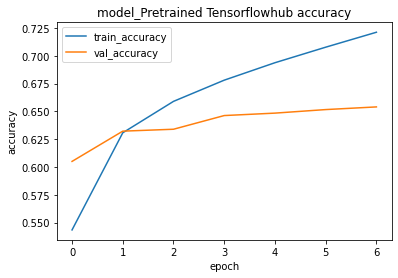

In [ ]:
##training vs Validation accuracy for Pretrained Tendorflow hub
plt.plot(hist_tfpret.history['acc'])
plt.plot(hist_tfpret.history['val_acc'])
plt.title('model_Pretrained Tensorflowhub accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy','val_accuracy'], loc='upper left')
plt.show()



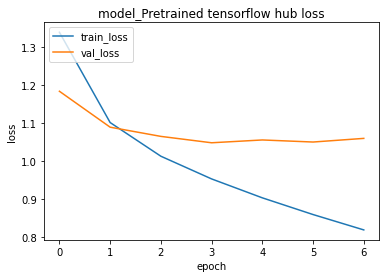

In [ ]:
##training vs Validation Loss for Pretrained Glove 
plt.plot(hist_tfpret.history['loss'])
plt.plot(hist_tfpret.history['val_loss'])
plt.title('model_Pretrained tensorflow hub loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'], loc='upper left')
plt.show()


In [ ]:
##evaluating on test data
##EVALUATION ON TEST DATA USING Pretrained Tensorflowhub
actual_testpreds=model_tfpret.predict(test_data["test_cleanedlyrics"])
actual_testpreds=actual_testpreds.argmax(axis=1)
final_testpred=le.inverse_transform(actual_testpreds)
actual_y=test_data["Genre"]
pred_y=final_testpred
print(confusion_matrix(actual_y, pred_y))
print(classification_report(actual_y, pred_y))


[[  0   0  11   0   0  24   6 120   0 649]
 [  0   0   0   0   0   2  52 300   0 306]
 [  0   0  36   0   0   8  23  89   0 339]
 [  0   0   0   1   0   2  13 848   0  96]
 [  0   0   1   0   0   4  16 147   0 342]
 [  0   0   6   0   0 164   4 137   0 349]
 [  0   0   1   0   0   0 487  72   0 250]
 [  0   0   2   0   0  23  21 598   0 466]
 [  0   0   1   0   0   9  25 192   0 283]
 [  0   0   4   0   0  11 103 315   0 977]]
              precision    recall  f1-score   support

     Country       0.00      0.00      0.00       810
  Electronic       0.00      0.00      0.00       660
        Folk       0.58      0.07      0.13       495
     Hip-Hop       1.00      0.00      0.00       960
       Indie       0.00      0.00      0.00       510
        Jazz       0.66      0.25      0.36       660
       Metal       0.65      0.60      0.62       810
         Pop       0.21      0.54      0.30      1110
         R&B       0.00      0.00      0.00       510
        Rock       0.24     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
##EVALUATION ON TEST DATA USING ModelPretrained tensorflow hub Overall Scores
##overall accuracy score
accuracy = accuracy_score(actual_y, pred_y)
print('Accuracy: %f' % accuracy)
#overall precision score
precision = precision_score(actual_y, pred_y,average='weighted')
print('Precision: %f' % precision)
#overall f1 score
f1 = f1_score(actual_y, pred_y,average='weighted')
print('F1 score: %f' % f1)
recal = recall_score(actual_y, pred_y,average='weighted')
print('recall score: %f' % recal)


Accuracy: 0.285192
Precision: 0.351191
F1 score: 0.208232
recall score: 0.285192


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
##Saving Pretrained model from tensorflowhub
model_tfpret.save("/content/drive/MyDrive/Assignment_data/model_tfpret.h5")
#https://drive.google.com/file/d/1auzMzSU9MaWIRoJ2pUBCHX0IPUHev0Bq/view?usp=sharing


#Building CNN Model

In [ ]:
### using CNN
num_filter = 250
filter_length = 3
hidden_dim = 250
num_epoch = 10

In [ ]:
#https://medium.com/voice-tech-podcast/text-classification-using-cnn-9ade8155dfb9 USE THIS one
top_words=10000
modelCNN = Sequential()
modelCNN.add(Embedding(top_words, 32, input_length=max_len))
modelCNN.add(Conv1D(32, 3, padding='same', activation='relu'))
modelCNN.add(MaxPooling1D())
modelCNN.add(Flatten())
modelCNN.add(Dense(6, activation='relu'))
modelCNN.add(Dense(10, activation='softmax'))
earlystop = EarlyStopping(monitor = 'val_loss',min_delta = 0,patience = 3, verbose = 1,restore_best_weights = True)
modelCNN.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 32)            320000    
_________________________________________________________________
conv1d (Conv1D)              (None, 50, 32)            3104      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 25, 32)            0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 4806      
_________________________________________________________________
dense_8 (Dense)              (None, 10)                70        
Total params: 327,980
Trainable params: 327,980
Non-trainable params: 0
________________________________________________

In [ ]:
modelCNN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
hist_cnn=modelCNN.fit(x_train, y_train, epochs=10,batch_size=128,validation_data=(x_valid, y_valid),verbose=2,callbacks=[earlystop])

Epoch 1/10
1814/1814 - 16s - loss: 1.3592 - accuracy: 0.4850 - val_loss: 1.2763 - val_accuracy: 0.5453
Epoch 2/10
1814/1814 - 15s - loss: 1.1889 - accuracy: 0.5790 - val_loss: 1.1779 - val_accuracy: 0.5862
Epoch 3/10
1814/1814 - 15s - loss: 1.0964 - accuracy: 0.6174 - val_loss: 1.1739 - val_accuracy: 0.5955
Epoch 4/10
1814/1814 - 15s - loss: 1.0178 - accuracy: 0.6505 - val_loss: 1.1798 - val_accuracy: 0.5994
Epoch 5/10
1814/1814 - 15s - loss: 0.9387 - accuracy: 0.6840 - val_loss: 1.2133 - val_accuracy: 0.5928
Epoch 6/10
1814/1814 - 15s - loss: 0.8692 - accuracy: 0.7116 - val_loss: 1.2624 - val_accuracy: 0.5954
Restoring model weights from the end of the best epoch.
Epoch 00006: early stopping


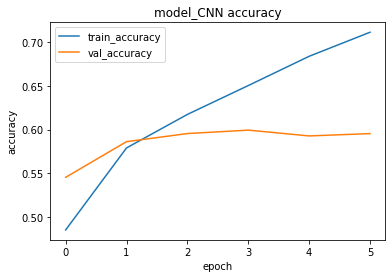

In [ ]:
##training vs Validation accuracy for CNN Model
plt.plot(hist_cnn.history['accuracy'])
plt.plot(hist_cnn.history['val_accuracy'])
plt.title('model_CNN accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy','val_accuracy'], loc='upper left')
plt.show()

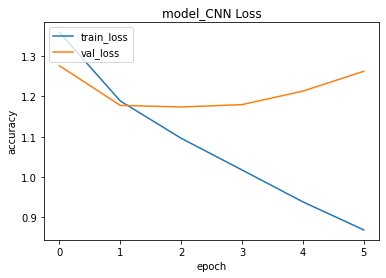

In [ ]:
##training vs Validation loss for CNN Model
plt.plot(hist_cnn.history['loss'])
plt.plot(hist_cnn.history['val_loss'])
plt.title('model_CNN Loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'], loc='upper left')
plt.show()

In [ ]:
##EVALUATION ON TEST DATA USING Model CNN
actual_testpreds=modelCNN.predict(testx_lyr)
actual_testpreds=actual_testpreds.argmax(axis=1)
final_testpred=le.inverse_transform(actual_testpreds)
actual_y=test_data["Genre"]
pred_y=final_testpred
print(confusion_matrix(actual_y, pred_y))
print(classification_report(actual_y, pred_y))

[[   0    0    0    0    0   20    6   67    0  717]
 [   0    0    0    0    0    6   46  195    0  413]
 [   0    0    0    0    0   17   22   53    0  403]
 [   0    0    0    2    0    4   23  678    0  253]
 [   0    0    0    0    0    4   20   72    0  414]
 [   0    0    0    0    0  125    7   79    0  449]
 [   0    0    0    0    0    2  368   58    0  382]
 [   0    0    0    0    0   20   25  372    0  693]
 [   0    0    0    0    0    7   27  136    0  340]
 [   0    0    0    0    0   11   85  170    0 1144]]
              precision    recall  f1-score   support

     Country       0.00      0.00      0.00       810
  Electronic       0.00      0.00      0.00       660
        Folk       0.00      0.00      0.00       495
     Hip-Hop       1.00      0.00      0.00       960
       Indie       0.00      0.00      0.00       510
        Jazz       0.58      0.19      0.29       660
       Metal       0.59      0.45      0.51       810
         Pop       0.20      0.34   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
##EVALUATION ON TEST DATA USING Model CNN Overall Scores
##overall accuracy score
accuracy = accuracy_score(actual_y, pred_y)
print('Accuracy: %f' % accuracy)
#overall precision score
precision = precision_score(actual_y, pred_y,average='weighted')
print('Precision: %f' % precision)
#overall f1 score
f1 = f1_score(actual_y, pred_y,average='micro')
print('F1 score: %f' % f1)
recal = recall_score(actual_y, pred_y,average='micro')
print('recall score: %f' % recal)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.253434
Precision: 0.295552
F1 score: 0.253434
recall score: 0.253434


In [ ]:
print(confusion_matrix(actual_y, pred_y))
print(classification_report(actual_y, pred_y))

[[   0    0    0    0    0   20    6   67    0  717]
 [   0    0    0    0    0    6   46  195    0  413]
 [   0    0    0    0    0   17   22   53    0  403]
 [   0    0    0    2    0    4   23  678    0  253]
 [   0    0    0    0    0    4   20   72    0  414]
 [   0    0    0    0    0  125    7   79    0  449]
 [   0    0    0    0    0    2  368   58    0  382]
 [   0    0    0    0    0   20   25  372    0  693]
 [   0    0    0    0    0    7   27  136    0  340]
 [   0    0    0    0    0   11   85  170    0 1144]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     Country       0.00      0.00      0.00       810
  Electronic       0.00      0.00      0.00       660
        Folk       0.00      0.00      0.00       495
     Hip-Hop       1.00      0.00      0.00       960
       Indie       0.00      0.00      0.00       510
        Jazz       0.58      0.19      0.29       660
       Metal       0.59      0.45      0.51       810
         Pop       0.20      0.34      0.25      1110
         R&B       0.00      0.00      0.00       510
        Rock       0.22      0.81      0.35      1410

    accuracy                           0.25      7935
   macro avg       0.26      0.18      0.14      7935
weighted avg       0.30      0.25      0.17      7935



Saving CNN Model

In [ ]:
##Saving Pretrained model from tensorflowhub
#modelCNN.save("/content/drive/MyDrive/Assignment_data/modelCNN.h5")
#https://drive.google.com/file/d/1-7bX57WspQicjrS9g4V65_6ApBrAiOJj/view?usp=sharing

